In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import nltk
import contractions
import keras
import tensorflow as tf
import keras_tuner as kt
import shap

%matplotlib inline

from tensorflow import keras

from wordcloud import WordCloud
from textblob import TextBlob

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from tqdm import tqdm
from collections import Counter

from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, Dropout
from tensorflow.keras.optimizers import Adam

c:\Users\laptop\Anaconda3\envs\TMLC_NLP\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Users\laptop\Anaconda3\envs\TMLC_NLP\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_orde

# Setup variables

In [2]:
only_english = set(nltk.corpus.words.words())
stops = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

vocab_set=''
tokenizer=''
max_length=''

_minimo=0
_inputs=0
_minimo=0

vocab_size=0

# Function definition

In [3]:
def clean_text(text):
    
    sample = text
    sample = " ".join([x.lower() for x in sample.split()])
    sample = re.sub(r"\S*https?:\S*", '', sample) #links and urls
    sample = re.sub('\[.*?\]', '', sample) #text between [square brackets]
    sample = re.sub('\(.*?\)', '', sample) #text between (parenthesis)
    sample = re.sub('#', ' ', sample) #remove hashtags
    sample = ' '.join([x for x in sample.split() if not x.startswith('@')]) # remove mentions with @
    sample = " ".join([contractions.fix(x) for x in sample.split()])  # fixes contractions like you're to you are
    sample = re.sub('[%s]' % re.escape(string.punctuation), ' ', sample) #punctuations
    sample = re.sub('\w*\d\w', '', sample) #digits with trailing or preceeding text
    sample = re.sub(r'\n', ' ', sample) #new line character
    sample = re.sub(r'\\n', ' ', sample) #new line character
    sample = re.sub("[''""...“”‘’…]", '', sample) #list of quotation marks
    sample = " ".join(x.strip() for x in sample.split()) #strips whitespace
    sample = re.sub(r', /<[^>]+>/', '', sample)    #HTML attributes
    
    sample = ' '.join(list(filter(lambda ele: re.search("[a-zA-Z\s]+", ele) is not None, sample.split()))) #languages other than english
    
    sample = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE).sub(r'', sample) #emojis and symbols
    sample = sample.strip()
    sample = " ".join([x.strip() for x in sample.split()])
    
    return sample

In [4]:
def get_wordnet_pos(word):
    
    treebank_tag = nltk.pos_tag([word])[0][1]
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


In [5]:
def correct_text(text, stem=False, lemma=False, spell=False):
    if lemma and stem:
        raise Exception('Either stem or lemma can be true, not both!')
        return text
    
    sample = text
    
    #removing stopwords
    sample = sample.lower()
    sample = [word for word in sample.split() if not word in stops]
    sample = ' '.join(sample)
    
    if lemma:
        sample = sample.split()
        sample = [lemmatizer.lemmatize(word.lower(), get_wordnet_pos(word.lower())) for word in sample]
        sample = ' '.join(sample)
        
    if stem:
        sample = sample.split()
        sample = [ps.stem(word) for word in sample]
        sample = ' '.join(sample)
    
    if spell:
        sample = str(TextBlob(text).correct())
    
    return sample

In [6]:
def build_vocab(vocab_obj, text):
    sample = text
    tokens = [word for word in sample.split()]
    vocab_obj.update(tokens)

In [7]:
def save__vocab_list(vocab, filename):
    lines = [a for a in vocab.keys()]
    # convert lines to a single blob of text
    data = '\n'.join(lines)
    # open file
    file = open(filename, 'w', encoding="utf-8")
    # write text
    file.write(data)
    # close file
    file.close()

In [8]:
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [9]:
def encode_docs(tokenizer, max_length, docs):
    # integer encode
    encoded = tokenizer.texts_to_sequences(docs)
    # pad sequences
    padded = pad_sequences(encoded, maxlen=max_length, padding='post')
    return padded

In [10]:
def define_model(vocab_size, max_length, n_words):
    model = Sequential()
    model.add(Embedding(vocab_size, 100, input_length=max_length))
    model.add(Flatten(input_shape=(n_words,)))
    model.add(Dense(45, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(0.0001)
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    model.summary()
    return model

In [13]:
def predict_sentiment(text, vocab=vocab_set, tokenizer=tokenizer, max_length=max_length, model=''):
    line = text
    # clean review
    line = clean_text(line)
    line = correct_text(line)
    line = " ".join([word for word in line.split() if word in vocab])
    # encode and pad review
    padded = encode_docs(tokenizer, max_length, [line])
    # predict sentiment
    yhat = model.predict(padded, verbose=0)
    # retrieve predicted percentage and label
    percent_pos = yhat[0,0]
    if round(percent_pos) == 0:
        return (1-percent_pos), 'NEGATIVE'
    return percent_pos, 'POSITIVE'

In [14]:
def plot_metric(h, p, v_p, m):
    plt.plot(h.history[p])
    plt.plot(h.history[v_p])
    plt.title('Model ' + m)
    plt.ylabel(m)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [15]:
def plot_loss(h):
    plt.plot(h.history['loss']) 
    plt.plot(h.history['val_loss']) 
    plt.title('Model loss') 
    plt.ylabel('Loss') 
    plt.xlabel('Epoch') 
    plt.legend(['Train', 'Test'], loc='upper left') 
    plt.show()

In [16]:
class MyHyperModel(kt.HyperModel):
  def build(self, hp):    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-5, 1e-6, 1e-7,1e-8])

    model = Sequential()
    model.add(Embedding(vocab_size, 60, input_length=max_length))
    model.add(Flatten(input_shape=(_inputs,)))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(hp_learning_rate)
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    model.summary()
    return model

In [17]:
def create_final_model(lr):
    model = Sequential()
    model.add(Embedding(vocab_size, 60, input_length=max_length))
    model.add(Flatten(input_shape=(_inputs,)))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(lr)
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    model.summary()    
    return model  

# Load Data

In [18]:
data = pd.read_csv("../data/raw/twitter_parsed_dataset.csv").drop(columns=['id', 'index', "Annotation"])
data.columns = ['text', 'label']

In [19]:
data

text  label
0      @halalflaws @biebervalue @greenlinerzjm I read...    0.0
1      @ShreyaBafna3 Now you idiots claim that people...    0.0
2      RT @Mooseoftorment Call me sexist, but when I ...    1.0
3      @g0ssipsquirrelx Wrong, ISIS follows the examp...    1.0
4                                 #mkr No No No No No No    0.0
...                                                  ...    ...
16846  Feeling so sorry for the girls, they should be...    0.0
16847  #MKR 'pretty good dishes we're happy with' - O...    0.0
16848  RT @colonelkickhead: Deconstructed lemon tart!...    0.0
16849  @versacezaynx @nyazpolitics @greenlinerzjm You...    0.0
16850  And before you protest that you're *not* mad, ...    0.0

[16851 rows x 2 columns]

In [20]:
data.dropna(subset=['text', 'label'], inplace=True)

In [21]:
data['text'].sample(1).values[0]

'RT @ChristineLockw2: Twitter makes me laugh....Better than the series ;)))))) Very funny 👏👏👏👏👏  #MKR'

([<matplotlib.axis.XTick at 0x1b883382e90>,
 [Text(0, 0, 'positive'), Text(1, 0, 'negative')])

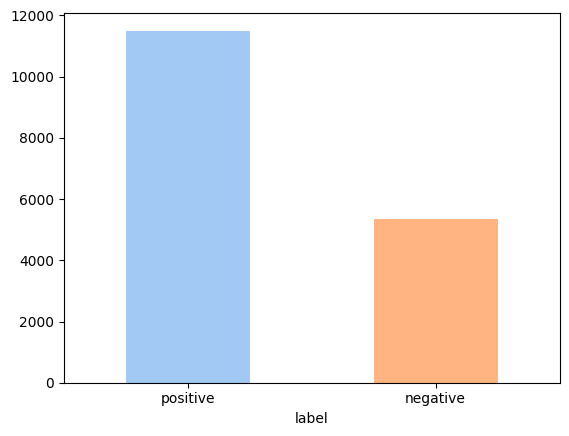

In [22]:
data['label'].value_counts().plot(kind='bar', color=sns.color_palette('pastel'))
plt.xticks([0,1],['positive', 'negative'], rotation=0)

# Preprocessing

In [23]:
data['cleaned_text'] = data['text'].apply(lambda x: clean_text(str(x)))
data

text  label  \
0      @halalflaws @biebervalue @greenlinerzjm I read...    0.0   
1      @ShreyaBafna3 Now you idiots claim that people...    0.0   
2      RT @Mooseoftorment Call me sexist, but when I ...    1.0   
3      @g0ssipsquirrelx Wrong, ISIS follows the examp...    1.0   
4                                 #mkr No No No No No No    0.0   
...                                                  ...    ...   
16846  Feeling so sorry for the girls, they should be...    0.0   
16847  #MKR 'pretty good dishes we're happy with' - O...    0.0   
16848  RT @colonelkickhead: Deconstructed lemon tart!...    0.0   
16849  @versacezaynx @nyazpolitics @greenlinerzjm You...    0.0   
16850  And before you protest that you're *not* mad, ...    0.0   

                                            cleaned_text  
0      i read them in context no change in meaning th...  
1      now you idiots claim that people who tried to ...  
2      rt call me sexist but when i go to an auto pla...  
3      wrong isis follows the example of mohammed and...  
4                                  mkr no no no no no no  
...                                                  ...  
16846  feeling so sorry for the girls they should be ...  
16847  mkr pretty good dishes we are happy with ok we...  
16848  rt deconstructed lemon tart can we please go j...  
16849              you are too stupid to talk to blocked  
16850  and before you protest that you are not mad th...  

[16848 rows x 3 columns]

In [24]:
data['correct_text'] = 'text'
data

text  label  \
0      @halalflaws @biebervalue @greenlinerzjm I read...    0.0   
1      @ShreyaBafna3 Now you idiots claim that people...    0.0   
2      RT @Mooseoftorment Call me sexist, but when I ...    1.0   
3      @g0ssipsquirrelx Wrong, ISIS follows the examp...    1.0   
4                                 #mkr No No No No No No    0.0   
...                                                  ...    ...   
16846  Feeling so sorry for the girls, they should be...    0.0   
16847  #MKR 'pretty good dishes we're happy with' - O...    0.0   
16848  RT @colonelkickhead: Deconstructed lemon tart!...    0.0   
16849  @versacezaynx @nyazpolitics @greenlinerzjm You...    0.0   
16850  And before you protest that you're *not* mad, ...    0.0   

                                            cleaned_text correct_text  
0      i read them in context no change in meaning th...         text  
1      now you idiots claim that people who tried to ...         text  
2      rt call me sexist but when i go to an auto pla...         text  
3      wrong isis follows the example of mohammed and...         text  
4                                  mkr no no no no no no         text  
...                                                  ...          ...  
16846  feeling so sorry for the girls they should be ...         text  
16847  mkr pretty good dishes we are happy with ok we...         text  
16848  rt deconstructed lemon tart can we please go j...         text  
16849              you are too stupid to talk to blocked         text  
16850  and before you protest that you are not mad th...         text  

[16848 rows x 4 columns]

In [25]:
count = 0
for text in tqdm(data['cleaned_text']):
    data['correct_text'][count] = correct_text(text, lemma=True)
    count +=1

  0%|          | 0/16848 [00:00<?, ?it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  0%|          | 1/16848 [00:04<21:43:57,  4.64s/it]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the cav

In [26]:
data['word_count'] = data['correct_text'].apply(lambda x: len(str(x).split(" ")))
data['char_count'] = data['correct_text'].str.len()

In [27]:
data = data[~(data['char_count'] == 0)].reset_index(drop=True)

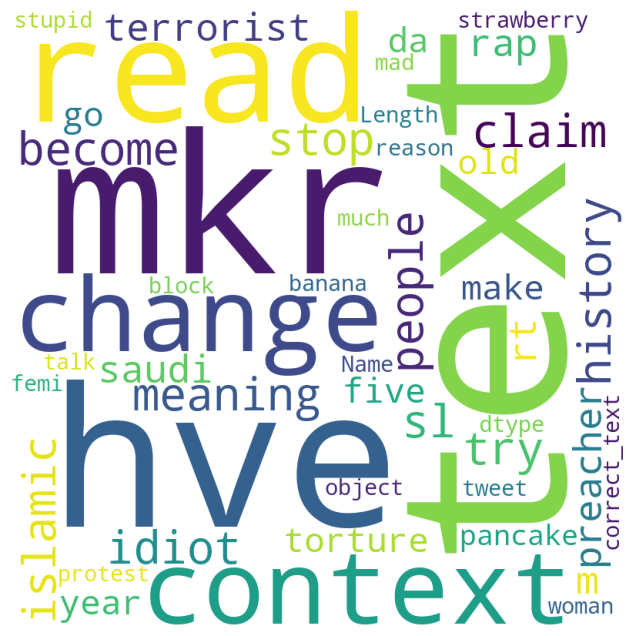

In [28]:
g = str(data[data['label']== 0]['correct_text'])

wordcloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(g)
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
  
plt.show()

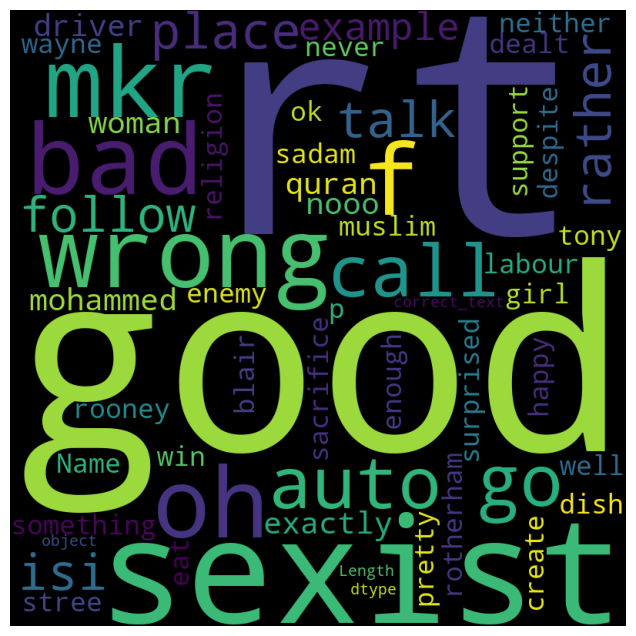

In [29]:
g = str(data[data['label']==1]['correct_text'])

wordcloud = WordCloud(width = 800, height = 800, background_color ='black', min_font_size = 10).generate(g)
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
  
plt.show()

In [30]:
final_data = data.drop(columns=['text', 'cleaned_text', 'word_count', 'char_count'])

In [31]:
vocab = Counter()
for text in final_data['correct_text']:
    build_vocab(vocab, text)

In [32]:
print(vocab.most_common(50))

[('mkr', 4939), ('rt', 3681), ('woman', 1235), ('kat', 1103), ('sexist', 1095), ('get', 1064), ('like', 1043), ('go', 990), ('islam', 926), ('muslim', 793), ('would', 747), ('people', 742), ('make', 707), ('amp', 691), ('one', 670), ('say', 626), ('think', 618), ('girl', 595), ('cannot', 555), ('know', 554), ('andre', 548), ('want', 526), ('see', 517), ('time', 482), ('isi', 481), ('look', 466), ('well', 453), ('call', 446), ('fuck', 428), ('really', 400), ('good', 398), ('men', 383), ('need', 379), ('thing', 372), ('right', 360), ('even', 322), ('oh', 305), ('way', 303), ('give', 303), ('u', 303), ('take', 303), ('talk', 300), ('female', 294), ('never', 291), ('bad', 290), ('use', 287), ('try', 285), ('year', 285), ('hate', 281), ('show', 278)]


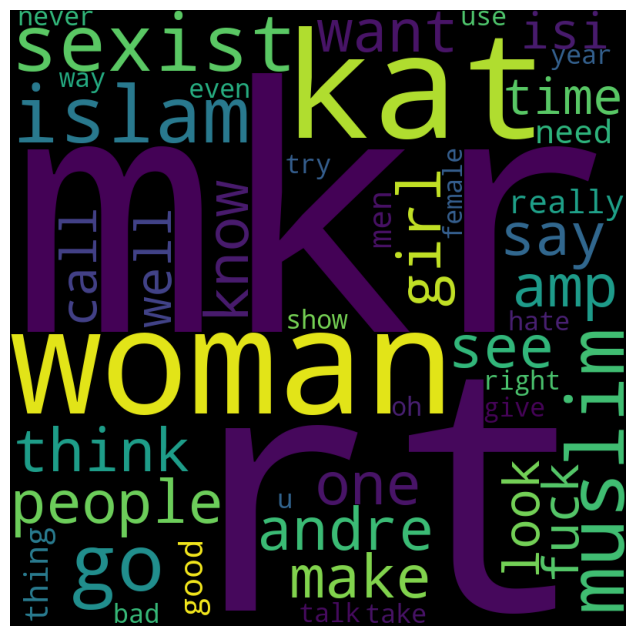

In [33]:
g = " ".join([x[0] for x in vocab.most_common(50)])
wordcloud = WordCloud(width = 800, height = 800, background_color ='black', min_font_size = 10).generate(g)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.show()

In [34]:
save__vocab_list(vocab, '../data/processed/vocab.txt')

In [35]:
X = final_data['correct_text']
y = final_data['label']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [37]:
X_train.fillna(" ", axis=0, inplace=True)
X_test.fillna(" ", axis=0, inplace=True)
y_train.fillna(0.0, inplace=True)
y_test.fillna(1.0, inplace=True)

In [38]:
vocab_set = set([x for x in vocab if len(x)>2])

tokenizer = create_tokenizer(X_train.values)
vocab_size = len(tokenizer.word_index) + 1
max_length = max([len(s.split()) for s in X_train])

In [39]:
x_train = encode_docs(tokenizer, max_length, X_train.values)
x_test = encode_docs(tokenizer, max_length, X_test.values)

# Modeling

In [40]:
Loss_call_back = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
_epoch = 100
_inputs =  x_train.shape[1]
_rows = x_train.shape[0]
_batch = 1500
_minimo = round(_inputs/5)


In [41]:
obj = kt.Objective('val_loss', 'min')

tunner = kt.RandomSearch(MyHyperModel(), 
                         objective = obj, 
                         seed=42,
                         max_trials = 5, 
                         overwrite=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 60)            629700    
                                                                 
 flatten (Flatten)           (None, 1380)              0         
                                                                 
 dense (Dense)               (None, 25)                34525     
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 664251 (2.53 MB)
Trainable params: 664251 (2.53 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [42]:
tunner.search(x_train, 
              y_train,
              epochs=_epoch,
              validation_data=(x_test, y_test), 
              batch_size= _batch,
              callbacks=[Loss_call_back])

Trial 4 Complete [00h 01m 47s]
val_loss: 0.6967750787734985

Best val_loss So Far: 0.6274328231811523
Total elapsed time: 00h 06m 49s
INFO:tensorflow:Oracle triggered exit


In [43]:
best_hps = tunner.get_best_hyperparameters(num_trials=1)[0]
print(f"""LEARNING RATE {best_hps.get('learning_rate')} """)

LEARNING RATE 1e-05 


In [44]:
final_model = create_final_model(best_hps.get('learning_rate'))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 23, 60)            629700    
                                                                 
 flatten_1 (Flatten)         (None, 1380)              0         
                                                                 
 dense_2 (Dense)             (None, 25)                34525     
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 664251 (2.53 MB)
Trainable params: 664251 (2.53 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [45]:
history = final_model.fit(x_train, 
                          y_train,
                          epochs=_epoch,
                          batch_size= _batch,
                          validation_data = (x_test,y_test ),
                          callbacks=[Loss_call_back])

Epoch 1/100
8/8 [==============================] - 3s 92ms/step - loss: 0.6982 - accuracy: 0.3705 - val_loss: 0.6977 - val_accuracy: 0.3742
Epoch 2/100
8/8 [==============================] - 0s 44ms/step - loss: 0.6969 - accuracy: 0.3883 - val_loss: 0.6965 - val_accuracy: 0.3966
Epoch 3/100
8/8 [==============================] - 0s 43ms/step - loss: 0.6957 - accuracy: 0.4141 - val_loss: 0.6953 - val_accuracy: 0.4204
Epoch 4/100
8/8 [==============================] - 0s 44ms/step - loss: 0.6945 - accuracy: 0.4451 - val_loss: 0.6941 - val_accuracy: 0.4584
Epoch 5/100
8/8 [==============================] - 0s 43ms/step - loss: 0.6933 - accuracy: 0.4871 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 6/100
8/8 [==============================] - 0s 43ms/step - loss: 0.6921 - accuracy: 0.5317 - val_loss: 0.6917 - val_accuracy: 0.5483
Epoch 7/100
8/8 [==============================] - 0s 44ms/step - loss: 0.6908 - accuracy: 0.5791 - val_loss: 0.6905 - val_accuracy: 0.5967
Epoch 8/100
8/8 [===

In [46]:
loss, acc = final_model.evaluate(x_test, y_test)
print('Test Acc: %f' % (acc))
print('Test Loss: %f' % (loss))

171/171 [==============================] - 1s 3ms/step - loss: 0.6287 - accuracy: 0.6822
Test Acc: 0.682168
Test Loss: 0.628699


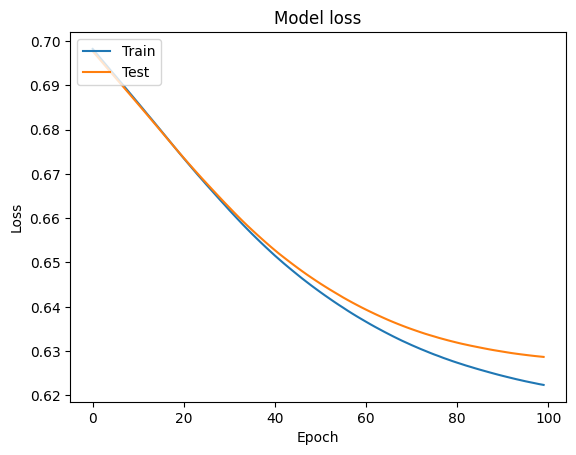

In [47]:
plot_loss(history)

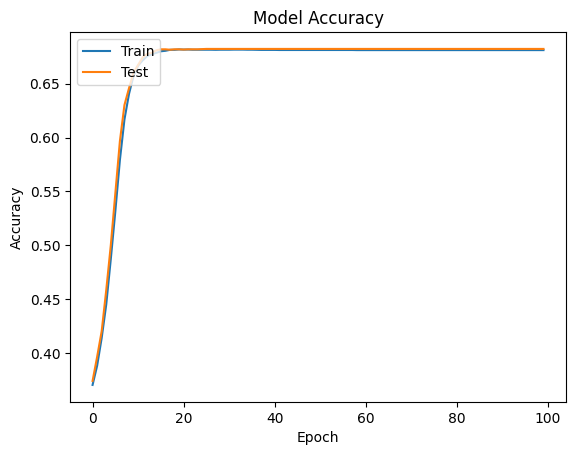

In [48]:
plot_metric(history, list(history.history)[1], list(history.history)[3], 'Accuracy')

# Simple test

In [49]:

percent, sentiment = predict_sentiment(final_data['correct_text'][200], vocab_set, tokenizer, max_length, final_model)
print(final_data['correct_text'][200] + ' ' + str(percent)  + ' ' + sentiment)

rt leak tape president erdogan told son bilal dispose million cash v 0.6501680016517639 NEGATIVE


# Save model

In [50]:
final_model.save('../models')

INFO:tensorflow:Assets written to: ../models\assets


INFO:tensorflow:Assets written to: ../models\assets


# Shap

In [51]:
shap.initjs()

In [52]:
samples = x_train[:100]

In [53]:
explainer = shap.KernelExplainer(final_model, samples)

In [54]:
shap_values = explainer.shap_values(x_test[:10])

100%|██████████| 10/10 [00:29<00:00,  2.91s/it]


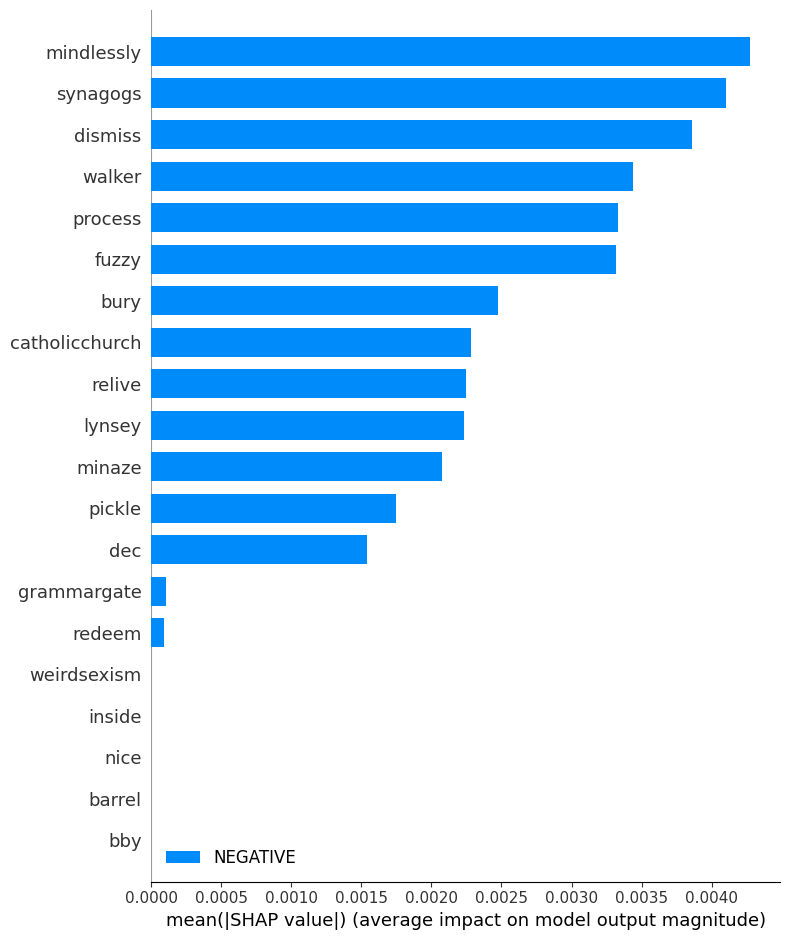

In [55]:
shap.summary_plot(shap_values, feature_names= list(vocab_set), class_names=["NEGATIVE", "POSITIVE"])

In [56]:
shap.force_plot(explainer.expected_value[0], shap_values[0], feature_names= [sentence for sentence in X_test[:10].values])